# Graded quiz. Непараметрические критерии

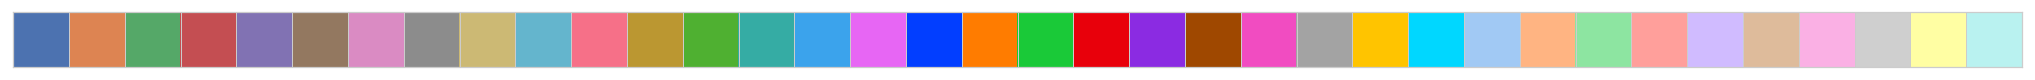

In [29]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
from sklearn import model_selection as mdsel
from statsmodels.stats import weightstats as wsts
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)
        
def r4(*kargs):
    return [round(x, 4) for x in kargs] if len(kargs) > 1 else round(kargs[0], 4)

def r4s(a):
    return r4(*a)

## 04. Question 4

Давайте вернёмся к данным выживаемости пациентов с лейкоцитарной лимфомой из видео про критерий знаков:

$49, 58, 75, 110, 112, 132, 151, 276, 281, 362^*$

Измерено остаточное время жизни с момента начала наблюдения (в неделях); звёздочка обозначает цензурирование сверху — исследование длилось 7 лет, и остаточное время жизни одного пациента, который дожил до конца наблюдения, неизвестно.

Поскольку цензурировано только одно наблюдение, для проверки гипотезы $H_0 \colon med X = 200$ на этих данных можно использовать критерий знаковых рангов — можно считать, что время дожития последнего пациента в точности равно 362, на ранг этого наблюдения это никак не повлияет.

Критерием знаковых рангов проверьте эту гипотезу против двусторонней альтернативы, введите достигаемый уровень значимости, округлённый до четырёх знаков после десятичной точки.

In [47]:
sample = np.array([49,58,75,110,112,132,151,276,281,362])

# sign test first
print 'sign test: ', r4(sign_test(sample, mu0=59)[1])

# wilcoxon signed rank test
print 'wilcoxon:  ', r4(sts.wilcoxon(sample - 200).pvalue)

sign test:  0.1094
wilcoxon:   0.2845


## 05. Question 5

В ходе исследования влияния лесозаготовки на биоразнообразие лесов острова Борнео собраны данные о количестве видов деревьев в 12 лесах, где вырубка не ведётся:

$22, 22, 15, 13, 19, 19, 18, 20, 21, 13, 13, 15,$

и в 9 лесах, где идёт вырубка:

$17, 18, 18, 15, 12, 4, 14, 15, 10$.

Проверьте гипотезу о равенстве среднего количества видов в двух типах лесов против односторонней альтернативы о снижении биоразнообразия в вырубаемых лесах. Используйте ранговый критерий. Чему равен достигаемый уровень значимости? Округлите до четырёх знаков после десятичной точки.

In [50]:
yes_sample = np.array([22,22,15,13,19,19,18,20,21,13,13,15])
no_sample = np.array([17,18,18,15,12,4,14,15,10])

result = sts.mannwhitneyu(yes_sample, no_sample)
print result

print r4(result[1])

MannwhitneyuResult(statistic=27.0, pvalue=0.02900499272087373)
0.029


## 06. Question 6

28 января 1986 года космический шаттл "Челленджер" взорвался при взлёте. Семь астронавтов, находившихся на борту, погибли. В ходе расследования причин катастрофы основной версией была неполадка с резиновыми уплотнительными кольцами в соединении с ракетными ускорителями. Для 23 предшествовавших катастрофе полётов "Челленджера" известны температура воздуха и появление повреждений хотя бы у одного из уплотнительных колец.

С помощью бутстрепа постройте 95% доверительный интервал для разности средних температур воздуха при запусках, когда уплотнительные кольца повреждались, и запусках, когда повреждений не было. Чему равна его ближайшая к нулю граница? Округлите до четырёх знаков после запятой.

Чтобы получить в точности такой же доверительный интервал, как у нас:

- установите random seed = 0 перед первым вызовом функции get_bootstrap_samples один раз
- сделайте по 1000 псевдовыборок из каждой выборки.

In [66]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

def get_diff_mean(sample_pair):
    return np.mean(sample_pair[0]) - np.mean(sample_pair[1])

data = pd.read_csv('data/18_challenger.txt', sep='\t', usecols=['Temperature', 'Incident'])
data.sample(2)

incidents_gen_sample = data[data.Incident == 1].Temperature.values
no_incidents_gen_sample = data[data.Incident == 0].Temperature.values

np.random.seed(0)

incident_means = np.mean(get_bootstrap_samples(incidents_gen_sample, 1000), axis=1)
no_incident_means = np.mean(get_bootstrap_samples(no_incidents_gen_sample, 1000), axis=1)

diff_means = incident_means - no_incident_means
print r4s(diff_means[:3])

diff_mean_confint = stat_intervals(diff_means)
print r4s(diff_mean_confint)
print r4(diff_mean_confint[1])

[-2.6339, -3.7634, -6.5527]
[-8.0646, -1.4504]
-1.4504


## 07. Question 7

На данных предыдущей задачи проверьте гипотезу об одинаковой средней температуре воздуха в дни, когда уплотнительный кольца повреждались, и дни, когда повреждений не было. Используйте перестановочный критерий и двустороннюю альтернативу. Чему равен достигаемый уровень значимости? Округлите до четырёх знаков после десятичной точки.

Чтобы получить такое же значение, как мы:

- установите random seed = 0;
- возьмите 10000 перестановок.

In [69]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)

    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]

    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample1, sample2, max_permutations = None, alternative = 'two-sided'):
    t_stat = permutation_t_stat_ind(sample1, sample2)
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    n = len(zero_distr)

    if alternative == 'two-sided':
        return float(np.sum(np.abs(zero_distr) >= abs(t_stat))) / n
    elif alternative == 'less':
        return float(np.sum(zero_distr <= t_stat)) / n
    elif alternative == 'greater':
        return float(np.sum(zero_distr >= t_stat)) / n
    else:
        raise ValueError("alternative not recognized: should be 'two-sided', 'less' or 'greater'")

np.random.seed(0)
permutation_test(incidents_gen_sample, no_incidents_gen_sample, max_permutations=10000)

0.0057